# Mental Health EDA and Predictive Analysis 
Data is thanks to Bhavik Jikadara on [kaggle.com](https://www.kaggle.com/datasets/bhavikjikadara/mental-health-dataset)

### Preface

I want to gain some insight into mental health, its factors, as well as what may make you more predisposed towards having mental health issues. I also want to gain more experience with using pytorch and its associated tools, therefore my modeling will be completed with pytorch packages and models.

### EDA and some data wrangling

In [1]:
# Loading data and packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("data/Mental Health Dataset.csv")
first_data = data.copy()

In [2]:
data.count().iloc[0]

292364

In [3]:
data.columns

Index(['Timestamp', 'Gender', 'Country', 'Occupation', 'self_employed',
       'family_history', 'treatment', 'Days_Indoors', 'Growing_Stress',
       'Changes_Habits', 'Mental_Health_History', 'Mood_Swings',
       'Coping_Struggles', 'Work_Interest', 'Social_Weakness',
       'mental_health_interview', 'care_options'],
      dtype='object')

In [4]:
data.head(5)

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,8/27/2014 11:29,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,8/27/2014 11:31,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,8/27/2014 11:32,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,8/27/2014 11:37,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,8/27/2014 11:43,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


We will be predicting whether someone has a history of mental health issues or not. This is a categorical variable, as such we will be using classification regression methods for prediction

In [5]:
# Looking at missing values
data.isnull().sum()

Timestamp                     0
Gender                        0
Country                       0
Occupation                    0
self_employed              5202
family_history                0
treatment                     0
Days_Indoors                  0
Growing_Stress                0
Changes_Habits                0
Mental_Health_History         0
Mood_Swings                   0
Coping_Struggles              0
Work_Interest                 0
Social_Weakness               0
mental_health_interview       0
care_options                  0
dtype: int64

It seems as if the self_employed column is the only one with missing values. Let's take a look at the type of values that could be given for that column

In [6]:
# There are three potential values that self_employed can take. 
data.self_employed.unique()

array([nan, 'No', 'Yes'], dtype=object)

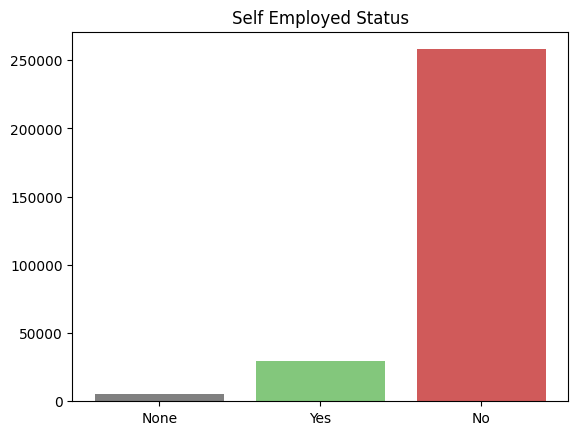

In [7]:
# Changing nan to be 'None' in the main dataset
data.loc[data.self_employed.isnull(), 'self_employed'] = 'None'
col = data.self_employed
y = col.groupby(col, dropna = False).count()
y = y.reindex(['None', 'Yes', 'No'])
x = y.index
fig = plt.bar(x, y, color = ['grey', '#83C77C', '#D05A5A'])
fig = plt.title('Self Employed Status')

Since the count for nan values are such a small proportion of the total dataset, I am more inclined to simply remove those values from the dataset, as I feel this would be possible to do without substantially impacting the accuracy of the resulting model. However, I do feel it would be interesting to impute models based on a classification model or K-means. I want to first create some naive models and compare the eventual accuracy between imputed data vs nonimputed data, however. For now, let's just keep this particular column in mind for eventual model creation

##### Mental Health History

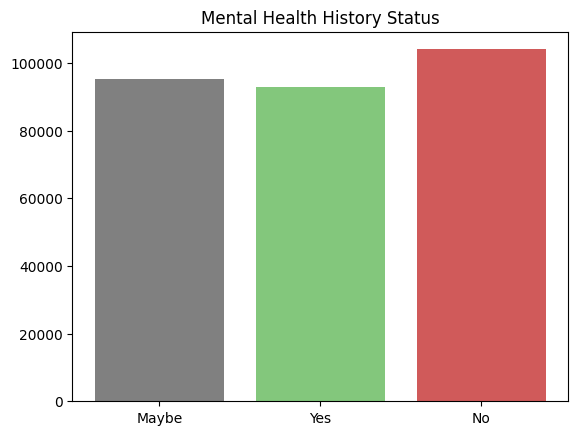

In [8]:
col = data.Mental_Health_History
y = col.groupby(col).count()
y = y.reindex(['Maybe', 'Yes', 'No'])
x = y.index
fig = plt.bar(x, y, color = ['grey', '#83C77C', '#D05A5A'])
fig = plt.title('Mental Health History Status')

Overall there is an even spread of values across yes, no and maybe, which bodes well for prediction. One consideration to take into account here, however, is that people may be uncomfortable or unwilling to disclose their truthful mental health history in a survey, resulting in a higher proportion of "No's" and "Maybe's" in the dataset than what may be truthful. The kaggle site did not mention whether this was a survey done in person or online, which depending on the specific mode of survey taking may make this factor more or less impactful in revealing the true situation.

In [9]:
# Transforming mental health history variable into three categories, -1 for No, 0 for Maybe, 1 for Yes
data.Mental_Health_History = data.Mental_Health_History.apply(lambda x: 0 if x == 'No' else 2 if x == 'Maybe' else 1)

##### Timestamp

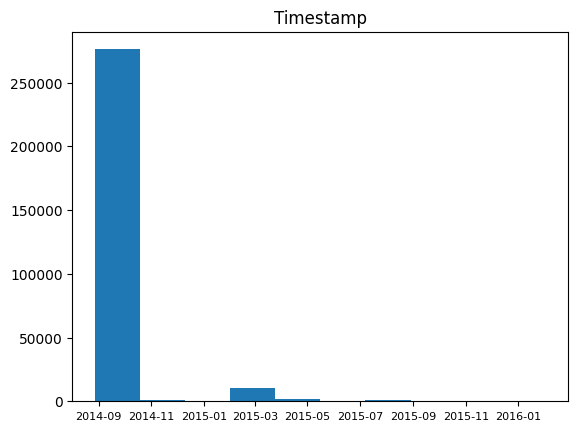

In [10]:
# Timestamp data is unable to really be categorized, need to change the datatype
data.Timestamp = pd.to_datetime(data.Timestamp)
x = data.Timestamp
fig = plt.hist(x)
fig = plt.xticks(fontsize = 8)
fig = plt.title('Timestamp')

Looks like most of the surveys were submitted exactly when the survey was put out. Overall I don't think this column will have much of an effect on prediction, given that the date someone completes a survey isn't likely at all to have any correlation to mental illness, etc.

##### Gender

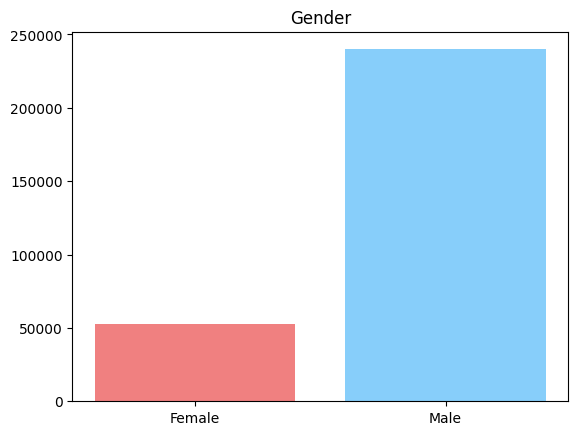

In [11]:
# Looking at gender types
col = data.Gender
y = col.groupby(col).count()
x = y.index
plt.bar(x, y, color = ['lightcoral', 'lightskyblue'])
fig = plt.title('Gender')

The smaller population of women compared to men will likely result in a reduction in accuracy for women, as well as potentially leading to biased results for either men or women in the eventual model.

In [12]:
# Transforming the gender into model usable variable
# I want to do this one by one to make it so that the column names will be more readable, etc.
# 0 will be female from now on, and 1 will be male
data.Gender = data.Gender.apply(lambda x: 0 if 'Female' else 1)

##### Country

In [13]:
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

world = gpd.read_file('data/ne_110m_admin_0_countries.shp')
col = data.Country
y = col.groupby(col).count()
x = y.index
countries = pd.DataFrame(np.array([x, y]).T)
countries = countries.rename({0: 'country', 1: 'count'}, axis = 1)
world = world.rename(columns={"NAME": "country"})
merged = pd.merge(world, countries, left_on = 'NAME_EN', right_on = 'country', how = 'left')

In [14]:
x, y = countries.country.count(), sum(merged['count'].notnull())
print(f'Before imputing.\nTotal countries with counts: {x}\nTotal countries in merged dataset with counts: {y}')
# Individually adding in count for countries that do not have the proper matching name
merged.loc[merged[(merged.NAME_EN == 'United States of America') == True].index, 'count'] = 171308
# There is no singapore, so we will put it as part of malaysia, this is due to the fault of the specific dataset not containing mapping data for singapore
merged.loc[merged[(merged.NAME_EN == 'Malaysia') == True].index, 'count'] = 780
x, y = countries.country.count(), sum(merged['count'].notnull())
print(f'After imputing.\nTotal countries with counts: {x}\nTotal countries in merged dataset with counts: {y}')
# Making count numeric and filling in missing values with 0
merged['count'] = pd.to_numeric(merged['count'])
merged['count'] = merged['count'].fillna(np.float64(0))

Before imputing.
Total countries with counts: 35
Total countries in merged dataset with counts: 33
After imputing.
Total countries with counts: 35
Total countries in merged dataset with counts: 35


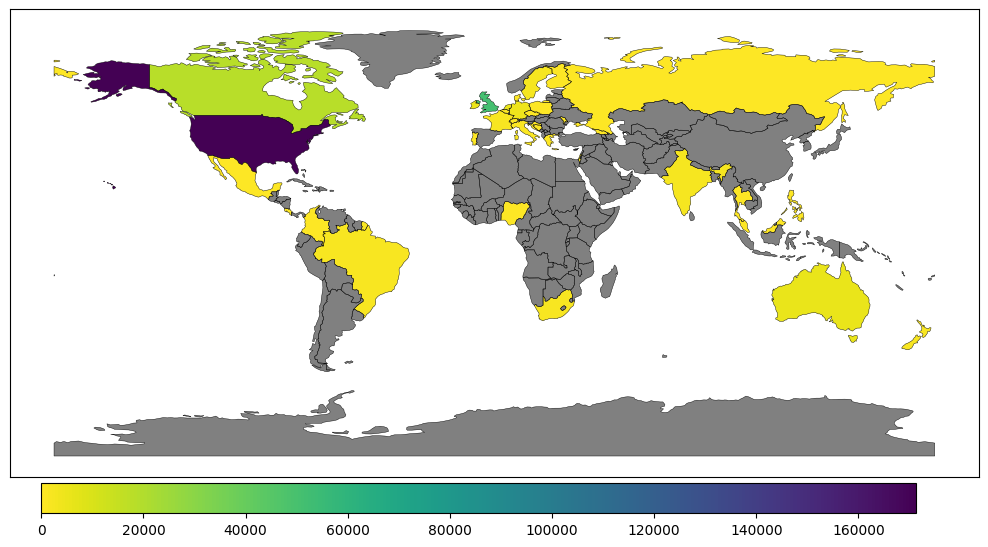

In [15]:
fig, ax = plt.subplots(1, 1, figsize = [12.5, 10])
norm = mcolors.Normalize(vmin = merged['count'].min(), vmax = merged['count'].max())
cmap = plt.get_cmap('viridis_r')
patches = []

ax.set_yticks([])
ax.set_xticks([])
merged.boundary.plot(ax = ax, linewidth = 0.3, color = 'black')
merged[merged['count'] != 0].plot(label = 'count', column = 'count', ax = ax,cmap = cmap)
merged[merged['count'] == 0].plot(ax=ax, color='gray')
# Creating legend
from matplotlib.colorbar import ColorbarBase
cbar_ax = fig.add_axes([0.15, 0.225, 0.7, 0.03])
cb = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')

From the plot above, we can see that most of the survey responses come from typically labelled "Western" countries, with Eastern country responses being more rare. This means that the results cannot be generalized for the entire populace, but only really for the countries that make up a large proportion of the survey responses. This also means that the mental health results also will not encompass countries such as China or South Korea, countries regularly shown in the news for mental health issues and problems, which may have been interesting to see. Overall it doesn't seem as if country will be a valuable predictor, considering that most of the responses come from only a few countries.

##### Occupation

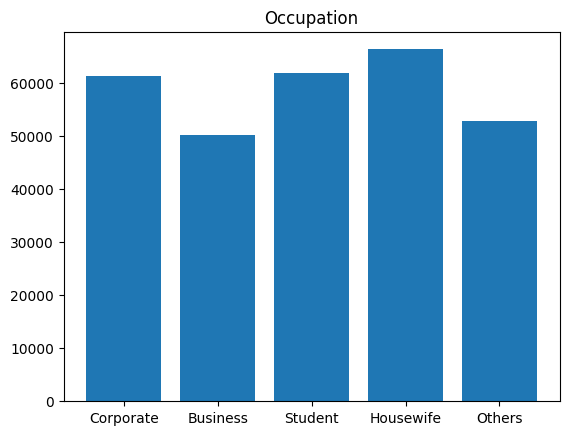

In [16]:
col = data.Occupation
y = col.groupby(col).count()
y = y.reindex(['Corporate', 'Business', 'Student', 'Housewife', 'Others'])
x = y.index
fig = plt.bar(x, y)
fig = plt.title('Occupation')

Overall there seems to be a pretty even spread of occupations within the dataset. I would enjoy it if there was a bit more elaboration on the others category to see the variation between the occupation types a bit more, as of right now though this category isn't anything too special.

##### Self_employed

Self employed was already looked at in the missing values exploration above. There is nothing much to note here except for the fact that there are a tremendous amount of No's as compared to Yes's in the data, which does indeed make sense given the current job climate. I would like to check whether there are differences in the self-employment rate within the occupation types, as it would make sense for certain positions to contain a higher proportion of self-employed people than others

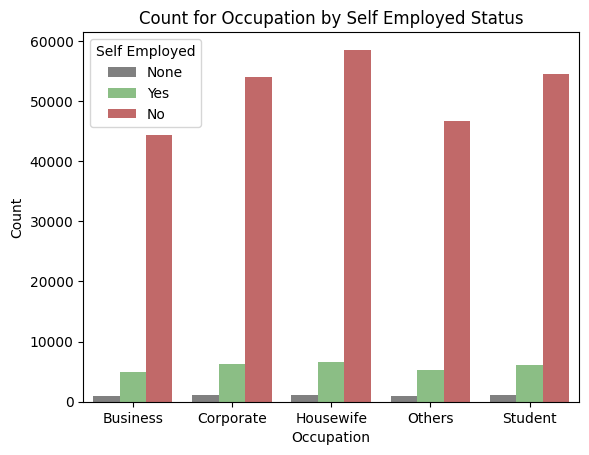

In [17]:
bar_data = data[['Timestamp', 'Occupation', 'self_employed']].groupby(['self_employed', 'Occupation']).count()
bar_data = bar_data.reset_index().rename(columns = {'self_employed': 'Self Employed', 'Timestamp':'Count'})
sns.barplot(data = bar_data, x = 'Occupation', y = 'Count', hue = 'Self Employed', hue_order = ['None', 'Yes', 'No'], palette = ['grey', '#83C77C', '#D05A5A'])
fig = plt.title('Count for Occupation by Self Employed Status')

##### Family_history

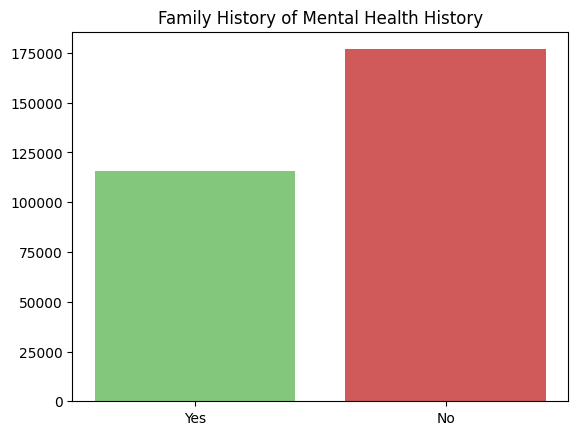

In [18]:
col = data.family_history
y = col.groupby(col).count()
y = y.reindex(['Yes', 'No'])
x = y.index
fig = plt.bar(x, y, color = ['#83C77C', '#D05A5A'])
fig = plt.title('Family History of Mental Health History')

Family history of mental illness also seems relatively equal between the two categories. I feel this will be a big factor in correctly predicting whether someone does have mental illness. 

In [19]:
# Changing family history to a numerical columns of 0's and 1's for easier model use
data.family_history = data.family_history.apply(lambda x: 1 if x == 'Yes' else 0)

Beyond these first few explored variables that stuck out to me, it doesn't seem like there are any others that would be imperative to discover. If there are any particularly intriguing variables that could be discovered to be important in prediction in models later on, I will take a look, otherwise I will get into regular data wrangling and cleaning before we begin the actual model creation.

##### Treatment

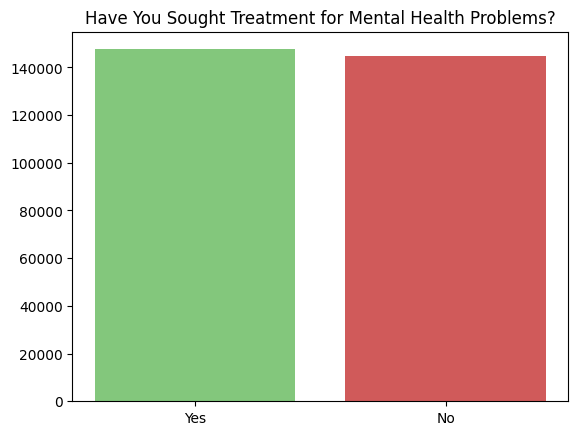

In [20]:
col = data.treatment
y = col.groupby(col).count()
y = y.reindex(['Yes', 'No'])
x = y.index
fig = plt.bar(x, y, color = ['#83C77C', '#D05A5A'])
fig = plt.title('Have You Sought Treatment for Mental Health Problems?')

Data for treatment seems very, very even here. This is pretty likely to be a good predictor for mental health history, especially considering the fact that treatment for mental health history issues itself is a very obvious indicator for whether someone has had mental health issues in the past. This may be a variable I will drop in the prediction process, simply because it is likely to be a hundred percent predictor for mental health history.

In [21]:
# Changing treatment into a usable variable
data.treatment = data.treatment.apply(lambda x: 1 if x == 'Yes' else 0)

##### Days indoors

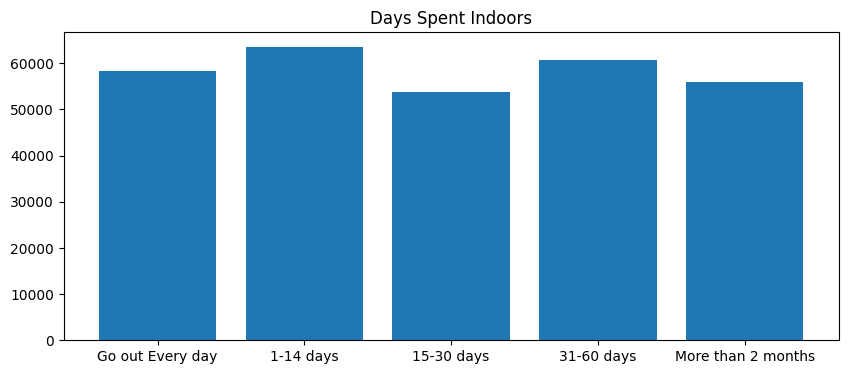

In [22]:
col = data.Days_Indoors
plt.figure(figsize = [10, 4])
y = col.groupby(col).count()
y = y.reindex(['Go out Every day', '1-14 days', '15-30 days', '31-60 days', 'More than 2 months'])
x = y.index
fig = plt.bar(x, y)
fig = plt.title('Days Spent Indoors')

Going out every day in itself logically would be a decent predictor of mental health history, especially considering the fact that sunlight and a lack of have been linked to depression and mental health issues (I believe, I have not done proper research on this although I should have). I am not going to transform this data due to the fact that there is not a simple yes or no categorical difference within this.

##### Growing stress

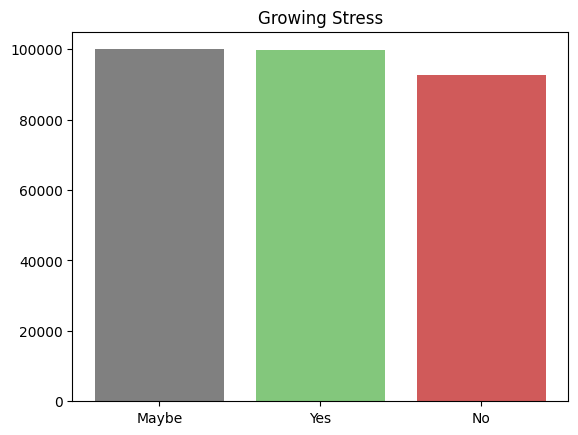

In [23]:
col = data.Growing_Stress
y = col.groupby(col).count()
y = y.reindex(['Maybe', 'Yes', 'No'])
x = y.index
fig = plt.bar(x, y, color = ['grey', '#83C77C', '#D05A5A'])
fig = plt.title('Growing Stress')

Seems like it would be a good predictor, moving on

In [24]:
# Changing into a usable variable
data.Growing_Stress = data.Growing_Stress.apply(lambda x: 0 if x == 'No' else 1 if x == 'Yes' else 2)

##### Changes Habits

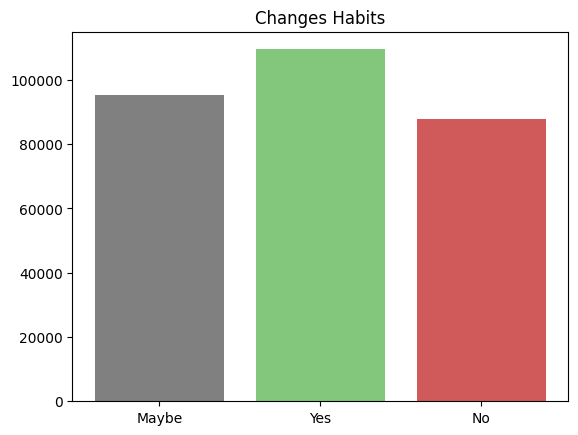

In [25]:
col = data.Changes_Habits
y = col.groupby(col).count()
y = y.reindex(['Maybe', 'Yes', 'No'])
x = y.index
fig = plt.bar(x, y, color = ['grey', '#83C77C', '#D05A5A'])
fig = plt.title('Changes Habits')

In [26]:
# Changing into a usable variable
data.Changes_Habits = data.Changes_Habits.apply(lambda x: 0 if x == 'No' else 1 if x == 'Yes' else 2)

##### Mood swings

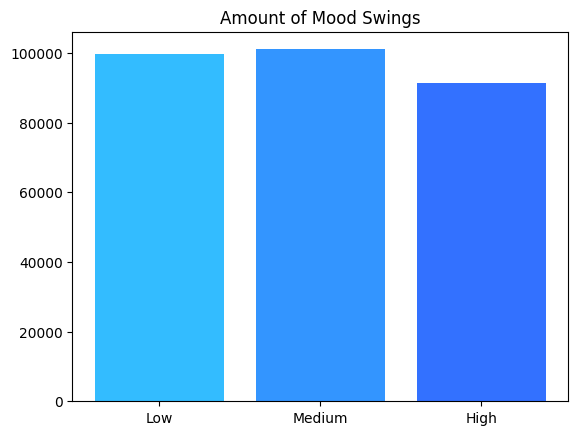

In [27]:
col = data.Mood_Swings
y = col.groupby(col).count()
y = y.reindex(['Low', 'Medium', 'High'])
x = y.index
fig = plt.bar(x, y, color = ['#33bcff', '#3395ff', '#3371ff'])
fig = plt.title('Amount of Mood Swings')

In [33]:
# Changing into a usable variable. This one will have 0 - low, and 2 - high
data.Mood_Swings = data.Mood_Swings.apply(lambda x: 0 if x == 'low' else 1 if x == 'Medium' else 2)

##### Coping Struggles

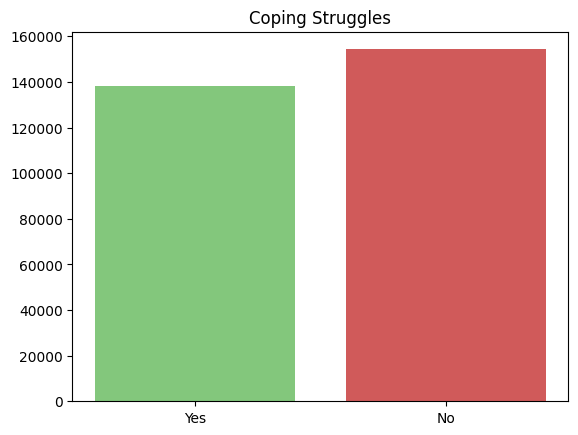

In [40]:
col = data.Coping_Struggles
y = col.groupby(col).count()
y = y.reindex(['Yes', 'No'])
x = y.index
plt.bar(x, y, color = ['#83C77C', '#D05A5A'])
fig = plt.title('Coping Struggles')

##### Work Interest

In [34]:
data.head(2)

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,2014-08-27 11:29:00,0,United States,Corporate,None,0,1,1-14 days,1,0,1,1,No,No,Yes,No,Not sure
1,2014-08-27 11:31:00,0,United States,Corporate,None,1,1,1-14 days,1,0,1,1,No,No,Yes,No,No


### Data Wrangling/Cleaning

I want to make a note on removing duplicates within the data. In this specific case, I do not believe we can assume there to be any duplicates within the data and here is why. There are no columns that can really serve as a unique identifier. The only one that could would be the 'Timestamp' column, but even is not a strong unique identifier. The timestamp column only keeps track of time down to the minute, which means that (especially given the high number of responses in this data) there is a chance that two people of very similar background will have submitted the same responses to the survey within the same minute, no matter how unlikely that may be. When you also consider the fact that percentage of "duplicated" values in the dataset is 0.79%, not dropping duplicated values seems to be the best course of action here.

In [29]:
print(f'This is the percentage of duplicated data: {round(data.duplicated().sum() / data.Timestamp.count() * 100, 2)}%')

This is the percentage of duplicated data: 0.79%


Now let us look at the missing values in self_employed and decide what to do with it. I will use a naive linear classification model to decide which method is more accurate: Imputation or Deletion. For imputation I will use KNN to decide what value to impute.

In [30]:
# First I need to change the data into dummies
data

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,2014-08-27 11:29:00,0,United States,Corporate,None,0,1,1-14 days,1,0,1,Medium,No,No,Yes,No,Not sure
1,2014-08-27 11:31:00,0,United States,Corporate,None,1,1,1-14 days,1,0,1,Medium,No,No,Yes,No,No
2,2014-08-27 11:32:00,0,United States,Corporate,None,1,1,1-14 days,1,0,1,Medium,No,No,Yes,No,Yes
3,2014-08-27 11:37:00,0,United States,Corporate,No,1,1,1-14 days,1,0,1,Medium,No,No,Yes,Maybe,Yes
4,2014-08-27 11:43:00,0,United States,Corporate,No,1,1,1-14 days,1,0,1,Medium,No,No,Yes,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292359,2015-07-27 23:25:00,0,United States,Business,Yes,1,1,15-30 days,0,2,0,Low,Yes,No,Maybe,Maybe,Not sure
292360,2015-08-17 09:38:00,0,South Africa,Business,No,1,1,15-30 days,0,2,0,Low,Yes,No,Maybe,No,Yes
292361,2015-08-25 19:59:00,0,United States,Business,No,1,0,15-30 days,0,2,0,Low,Yes,No,Maybe,No,No
292362,2015-09-26 01:07:00,0,United States,Business,No,1,1,15-30 days,0,2,0,Low,Yes,No,Maybe,No,Yes
